# Imports & Configuration

In [1]:
import SimpleITK as sitk
import numpy as np
import glob
import os
import tifffile
import matplotlib.pyplot as plt
from IPython.display import clear_output
import config


DATA_BASE_PATH = os.path.join(config.DATASPACE, "TMA_Cores_Grouped_NEW")
WORK_OUTPUT= os.path.join(config.DATASPACE, "Registered")
TARGET_CORE = "Core_11" 

INPUT_FOLDER = os.path.join(DATA_BASE_PATH, TARGET_CORE)
OUTPUT_FOLDER =  os.path.join(WORK_OUTPUT, "test")
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Get sorted file list
file_list = sorted(glob.glob(os.path.join(INPUT_FOLDER, "*.ome.tif")))
print(f"Target: {TARGET_CORE} | Found {len(file_list)} slices")
print(f"Output: {WORK_OUTPUT} ")



Target: Core_11 | Found 20 slices
Output: /data3/junming/3D-TMA-Register/Registered 


# VISUALIZATION HELPER

In [2]:
def show_live_check(fixed, moving, slice_num, direction):
    clear_output(wait=True)
    
    # 1. Downsample (8x)
    f = sitk.GetArrayFromImage(fixed)[::8, ::8]
    m = sitk.GetArrayFromImage(moving)[::8, ::8]
    
    # 2. ROBUST NORMALIZATION 
    # Instead of dividing by max(), we divide by the 99th percentile.
    # This ignores the super-bright outliers and brightens the tissue.
    def robust_norm(x):
        p99 = np.percentile(x, 99) 
        if p99 == 0: p99 = 1 # Avoid division by zero
        return np.clip(x / p99, 0, 1) # Scale and clip everything above p99 to 1.0
    
    f_norm = robust_norm(f)
    m_norm = robust_norm(m)
    
    # 3. Create Composite
    # Fixed = Red, Moving = Green
    rgb = np.dstack((f_norm, m_norm, np.zeros_like(f_norm)))
    
    # 4. Plot
    plt.figure(figsize=(10, 5))
    plt.imshow(rgb)
    plt.title(f"{direction}: Slice {slice_num}\n(Yellow=Aligned, Red/Green=Shifted)")
    plt.axis('off')
    plt.show()

#  Helper Function

In [3]:
import time 

def register_slice_with_metrics(fixed_full_image, moving_full_image):
    """
    EVOLUTIONARY STRATEGY + TIMER
    Returns: (Image, Metrics, Runtime_Seconds)
    """
    
    # A. CAST TO FLOAT32
    fixed_dapi = sitk.Cast(fixed_full_image[:, :, 0], sitk.sitkFloat32)
    moving_dapi = sitk.Cast(moving_full_image[:, :, 0], sitk.sitkFloat32)
    
    # B. INITIALIZATION (MOMENTS)
    initial_tx = sitk.CenteredTransformInitializer(
        fixed_dapi, moving_dapi, 
        sitk.Euler2DTransform(), 
        sitk.CenteredTransformInitializerFilter.MOMENTS
    )
    
    # C. SETUP REGISTRATION
    reg = sitk.ImageRegistrationMethod()
    
    # Robust Pyramid
    reg.SetShrinkFactorsPerLevel([8, 4, 2])
    reg.SetSmoothingSigmasPerLevel([2, 1, 0])
    reg.SetSmoothingSigmasAreSpecifiedInPhysicalUnits(False)
    
    # Metric: Mattes MI
    reg.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    reg.SetMetricSamplingStrategy(reg.RANDOM)
    reg.SetMetricSamplingPercentage(0.20)
    
    # Optimizer: Evolutionary
    reg.SetOptimizerAsOnePlusOneEvolutionary(
        numberOfIterations=300, 
        epsilon=1e-6,           
        initialRadius=1.5,      
        growthFactor=1.1,       
        shrinkFactor=0.9        
    )
    
    reg.SetInitialTransform(initial_tx)
    
    # Tracking
    metric_values = []
    def on_iteration():
        metric_values.append(reg.GetMetricValue())
    reg.AddCommand(sitk.sitkIterationEvent, on_iteration)
    
    # D. EXECUTE (WITH TIMER)
    start_time = time.time() # <--- Start Clock
    try:
        final_tx = reg.Execute(fixed_dapi, moving_dapi)
    except Exception as e:
        print(f"  Warning: {e}")
        return moving_full_image, [], 0.0 # Return 0 time on fail
    end_time = time.time() # <--- Stop Clock
    
    execution_time = end_time - start_time
    
    # E. APPLY (Back to UInt16)
    rotated_channels = []
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed_dapi)
    resampler.SetTransform(final_tx)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(0)
    
    for c in range(8):
        chan = moving_full_image[:, :, c]
        aligned_chan = resampler.Execute(chan)
        rotated_channels.append(aligned_chan)
        
    aligned_full_image = sitk.JoinSeries(rotated_channels)
    aligned_full_image = sitk.Cast(aligned_full_image, sitk.sitkUInt16)
    
    return aligned_full_image, metric_values, execution_time # <--- Return Time

In [4]:
# --- DASHBOARD VISUALIZATION ---
def show_dashboard(fixed, moving, metrics, slice_num, direction, runtime):
    clear_output(wait=True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # --- LEFT: IMAGE ---
    f = sitk.GetArrayFromImage(fixed)[::8, ::8]
    m = sitk.GetArrayFromImage(moving)[::8, ::8]
    
    def robust_norm(x):
        p99 = np.percentile(x, 99) 
        if p99 == 0: p99 = 1
        return np.clip(x / p99, 0, 1)
    
    rgb = np.dstack((robust_norm(f), robust_norm(m), np.zeros_like(f)))
    ax1.imshow(rgb)
    ax1.set_title(f"{direction}: Slice {slice_num}\n(Yellow=Aligned)")
    ax1.axis('off')
    
    # --- RIGHT: PLOT ---
    if metrics:
        ax2.plot(metrics, color='blue', linewidth=2)
        ax2.set_title(f"Evolutionary Trace ({runtime:.2f} sec)") 
        ax2.set_xlabel("Iteration Step")
        ax2.set_ylabel("Mutual Information (Lower is Better)")
        ax2.grid(True, linestyle='--', alpha=0.5)
        
        final_val = metrics[-1]
        ax2.plot(len(metrics)-1, final_val, 'ro')
        ax2.text(len(metrics)-1, final_val, f" {final_val:.3f}", color='red', fontweight='bold')
    else:
        ax2.text(0.5, 0.5, "Registration Failed", ha='center')
    
    plt.tight_layout()
    plt.show()

# Main Loop

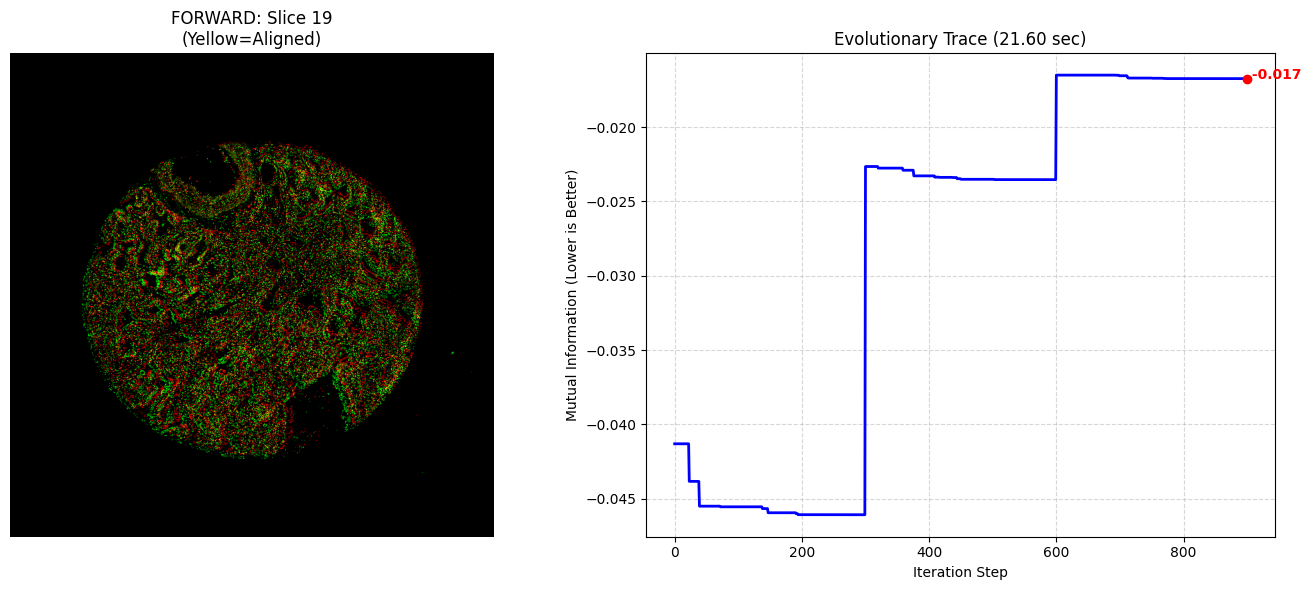

In [5]:

total_slices = len(file_list)
aligned_results = [None] * total_slices
registration_stats = [] 

# Anchor
center_idx = total_slices // 2
center_full = sitk.ReadImage(file_list[center_idx])
aligned_results[center_idx] = center_full
print(f"--- Anchor: Slice {center_idx} ---")

# BACKWARD
print("\n>>> BACKWARD")
current_fixed = center_full
for i in range(center_idx - 1, -1, -1):
    moving = sitk.ReadImage(file_list[i])
    
    # Get Time here
    aligned, metrics, runtime = register_slice_with_metrics(current_fixed, moving)
    
    aligned_results[i] = aligned
    
    final_score = metrics[-1] if metrics else 0
    registration_stats.append({
        "Direction": "Backward",
        "Moving_Slice": i,
        "Fixed_Ref": i + 1,
        "Final_Metric": final_score,
        "Iterations": len(metrics),
        "Runtime(s)": round(runtime, 2)
    })
    
    show_dashboard(current_fixed[:,:,0], aligned[:,:,0], metrics, i, "BACKWARD", runtime)
    
    current_fixed = aligned

# FORWARD
print("\n>>> FORWARD")
current_fixed = center_full
for i in range(center_idx + 1, total_slices):
    moving = sitk.ReadImage(file_list[i])
    
    aligned, metrics, runtime = register_slice_with_metrics(current_fixed, moving)
    
    aligned_results[i] = aligned
    
    final_score = metrics[-1] if metrics else 0
    registration_stats.append({
        "Direction": "Forward",
        "Moving_Slice": i,
        "Fixed_Ref": i - 1,
        "Final_Metric": final_score,
        "Iterations": len(metrics),
        "Runtime(s)": round(runtime, 2) 
    })

    show_dashboard(current_fixed[:,:,0], aligned[:,:,0], metrics, i, "FORWARD", runtime)
    
    current_fixed = aligned

# Evaluate

In [6]:
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
# Create DataFrame
df = pd.DataFrame(registration_stats)

# Reorder columns
df = df[["Direction", "Moving_Slice", "Fixed_Ref", "Final_Metric", "Iterations", "Runtime(s)"]]

# Sort by Slice Number
df = df.sort_values(by="Moving_Slice")

print("--- REGISTRATION QUALITY & PERFORMANCE REPORT ---")
try:
    display(df) 
except:
    print(df.to_string(index=False))


--- REGISTRATION QUALITY & PERFORMANCE REPORT ---


,Direction,Moving_Slice,Fixed_Ref,Final_Metric,Iterations,Runtime(s)
9,Backward,0,1,-0.002822,900,20.92
8,Backward,1,2,-0.002956,900,20.75
7,Backward,2,3,-0.027495,900,21.16
6,Backward,3,4,-0.022804,900,21.02
5,Backward,4,5,-0.023922,900,21.26
4,Backward,5,6,-0.017917,900,21.13
3,Backward,6,7,-0.032063,900,21.17
2,Backward,7,8,-0.017592,900,21.44
1,Backward,8,9,-0.018662,900,21.38
0,Backward,9,10,-0.015580,900,21.41


# Save Result

In [ ]:
output_path = os.path.join(OUTPUT_FOLDER, f"{TARGET_CORE}_CenterOut_Aligned.ome.tif")
print(f"Saving to {output_path}...")

# Filter out any 'None' values just in case
valid_slices = [img for img in aligned_results if img is not None]

# Convert ITK (X,Y,8) -> Numpy (Z, 8, Y, X)
# GetArrayFromImage returns (8, Y, X). Stacking gives (Z, 8, Y, X).
vol = np.array([sitk.GetArrayFromImage(img) for img in valid_slices])

print(f"Final Volume Shape: {vol.shape}")

tifffile.imwrite(
    output_path, 
    vol, 
    photometric='minisblack',
    metadata={'axes': 'ZCYX'}
)
print("Done.")

In [7]:
import tifffile
import os
import numpy as np


print("SAVING REGISTERED VOLUME FOR FIJI")

# Define output path
output_tiff = os.path.join(OUTPUT_FOLDER, f"{TARGET_CORE}_CenterOut_Aligned.ome.tif")

print(f"\n Output file: {output_tiff}")

# Convert aligned results to volume
valid_slices = [img for img in aligned_results if img is not None]
vol = np.array([sitk.GetArrayFromImage(img) for img in valid_slices])

print(f"\n Volume Dimensions:")
print(f"   Shape: {vol.shape}")
print(f"   Z-slices: {vol.shape[0]}")
print(f"   Channels: {vol.shape[1]}")
print(f"   Height: {vol.shape[2]} pixels")
print(f"   Width: {vol.shape[3]} pixels")
print(f"   Total size: {vol.nbytes / 1e9:.2f} GB in memory")

# Channel metadata for FIJI
channel_names = ['DAPI', 'CD3', 'CD8', 'CD20', 'CD68', 'PanCK', 'Ki67', 'Autofluor']

# Save as OME-TIFF with proper metadata for FIJI
print(f"\n Saving OME-TIFF...")

tifffile.imwrite(
    output_tiff, 
    vol,
    photometric='minisblack',
    metadata={
        'axes': 'ZCYX',
        'Channel': {'Name': channel_names[:vol.shape[1]]},
    },
    compression='zlib'  # Compress to reduce file size
)

file_size_mb = os.path.getsize(output_tiff) / 1e6

print(f" SAVED SUCCESSFULLY!")
print(f"   File: {os.path.basename(output_tiff)}")
print(f"   Size: {file_size_mb:.1f} MB")


SAVING REGISTERED VOLUME FOR FIJI

 Output file: /data3/junming/3D-TMA-Register/Registered/test/Core_11_CenterOut_Aligned.ome.tif

 Volume Dimensions:
   Shape: (20, 8, 6048, 6048)
   Z-slices: 20
   Channels: 8
   Height: 6048 pixels
   Width: 6048 pixels
   Total size: 11.71 GB in memory

 Saving OME-TIFF...
 SAVED SUCCESSFULLY!
   File: Core_11_CenterOut_Aligned.ome.tif
   Size: 1649.2 MB


# Quality Check Previews

GENERATING QUALITY CHECK PREVIEWS

1️  Multi-channel preview (Key slices)...


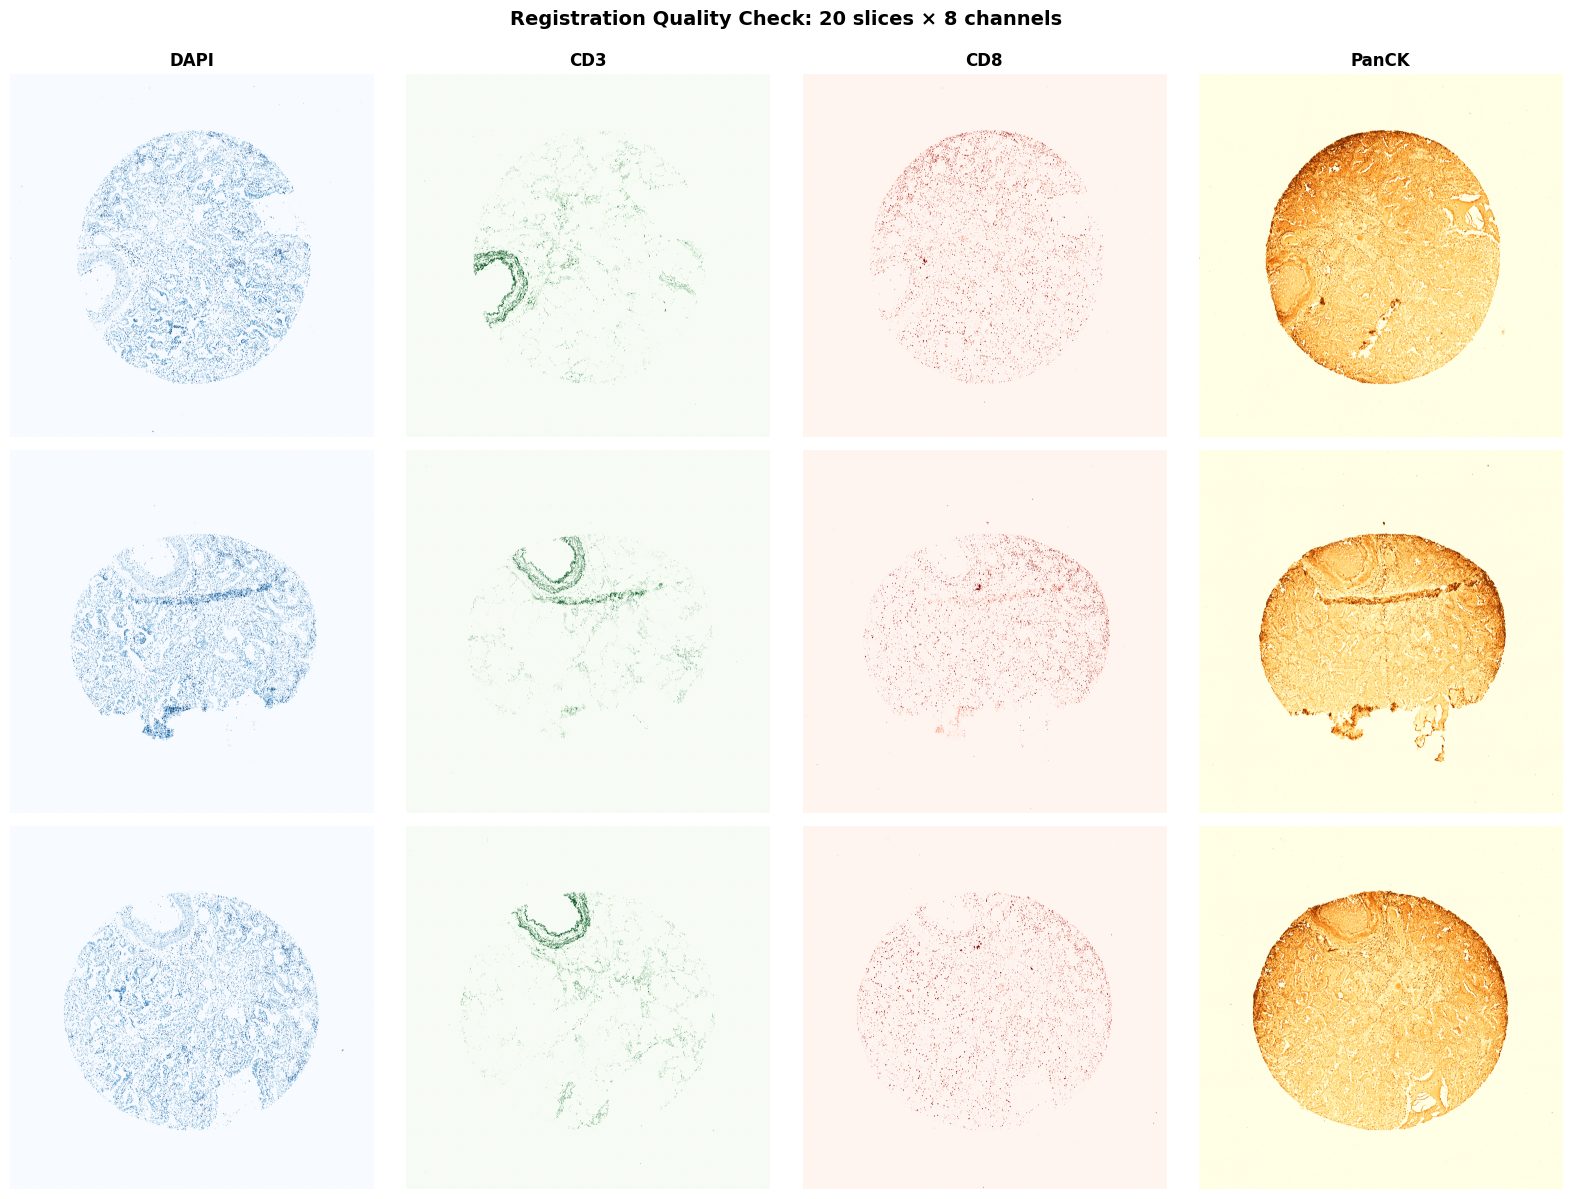


2️  RGB overlay (Check alignment)...


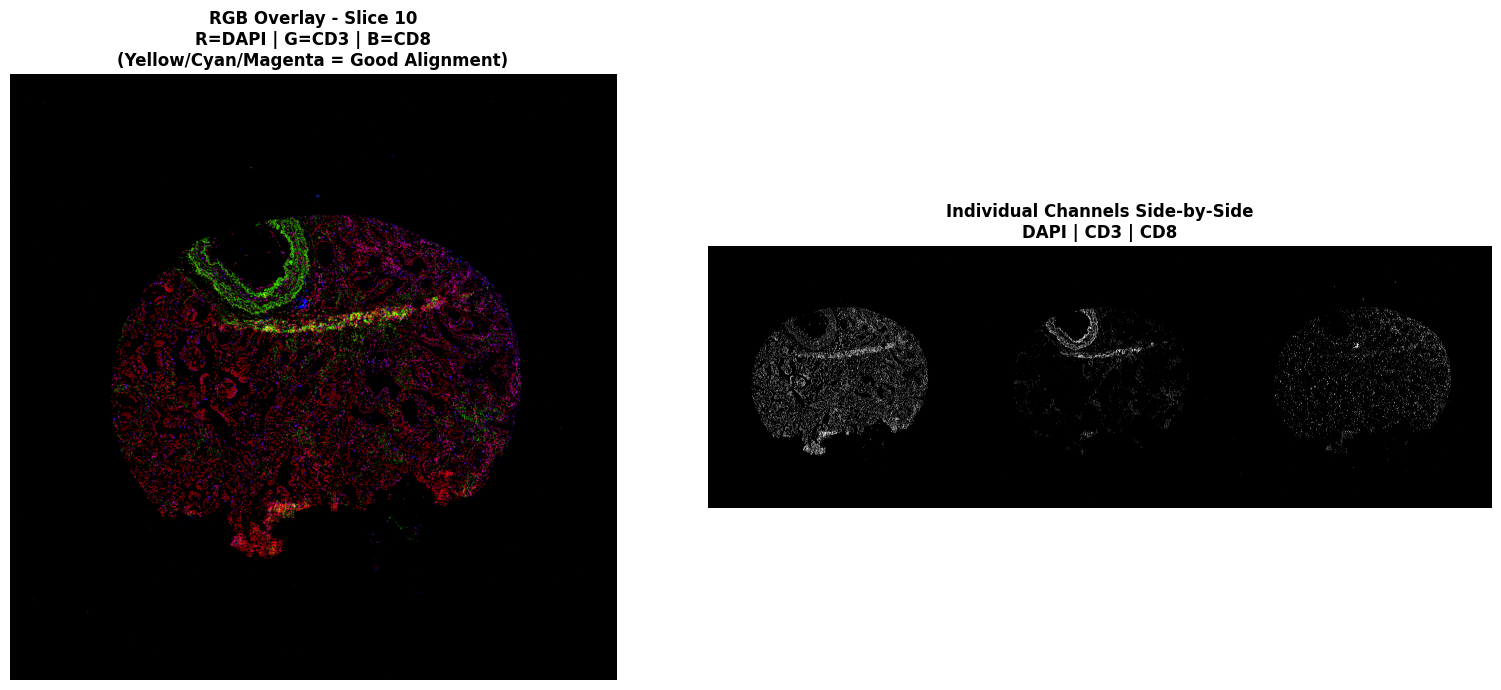


3️  Z-stack montage (DAPI channel)...


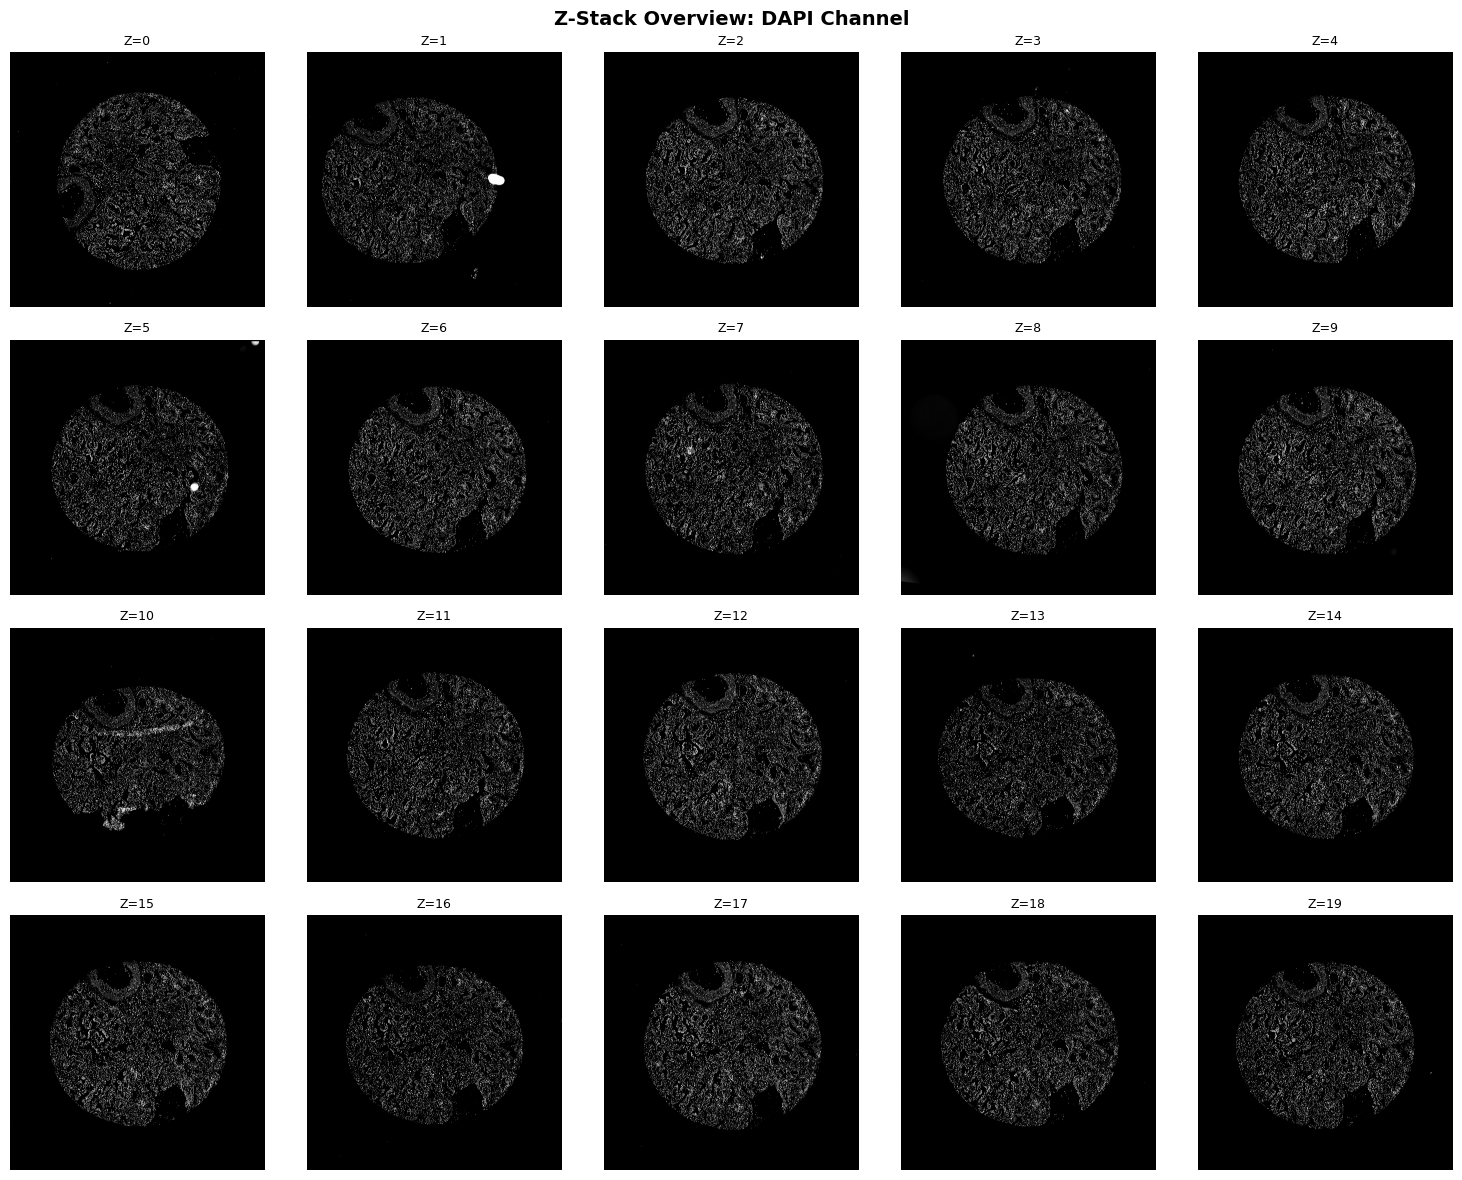


 Preview complete! If tissue looks good, proceed to download.


In [ ]:
import matplotlib.pyplot as plt

print("GENERATING QUALITY CHECK PREVIEWS")

def preview_slice_grid(vol, slice_indices=None, channels=[0, 1, 2, 5]):
    """
    Show a grid of slices and channels for quality checking
    """
    channel_names = ['DAPI', 'CD3', 'CD8', 'CD20', 'CD68', 'PanCK', 'Ki67', 'Auto']
    colormaps = ['Blues', 'Greens', 'Reds', 'Purples', 'Oranges', 'YlOrBr', 'Greys', 'gray']
    
    if slice_indices is None:
        # Show start, middle, and end slices
        n_slices = vol.shape[0]
        slice_indices = [0, n_slices // 2, n_slices - 1]
    
    n_rows = len(slice_indices)
    n_cols = len(channels)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    if n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    for row, z_idx in enumerate(slice_indices):
        for col, ch_idx in enumerate(channels):
            img = vol[z_idx, ch_idx, :, :]
            
            # Robust contrast
            vmax = np.percentile(img, 99.5)
            
            axes[row, col].imshow(img, cmap=colormaps[ch_idx], vmin=0, vmax=vmax)
            
            # Labels
            if row == 0:
                axes[row, col].set_title(f'{channel_names[ch_idx]}', 
                                        fontsize=12, fontweight='bold')
            if col == 0:
                axes[row, col].set_ylabel(f'Slice {z_idx}', 
                                         fontsize=11, fontweight='bold')
            
            axes[row, col].axis('off')
    
    plt.suptitle(f'Registration Quality Check: {vol.shape[0]} slices × {vol.shape[1]} channels', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()


def preview_rgb_overlay(vol, slice_idx=None, rgb_channels=[0, 1, 2]):
    """
    RGB overlay to verify channel alignment
    """
    if slice_idx is None:
        slice_idx = vol.shape[0] // 2
    
    channel_names = ['DAPI', 'CD3', 'CD8', 'CD20', 'CD68', 'PanCK', 'Ki67', 'Auto']
    
    # Extract channels
    r = vol[slice_idx, rgb_channels[0], :, :]
    g = vol[slice_idx, rgb_channels[1], :, :]
    b = vol[slice_idx, rgb_channels[2], :, :]
    
    # Normalize
    def norm(x):
        p99 = np.percentile(x, 99.5)
        return np.clip(x / (p99 if p99 > 0 else 1), 0, 1)
    
    rgb = np.dstack((norm(r), norm(g), norm(b)))
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Overlay
    axes[0].imshow(rgb)
    axes[0].set_title(f'RGB Overlay - Slice {slice_idx}\n' +
                     f'R={channel_names[rgb_channels[0]]} | ' +
                     f'G={channel_names[rgb_channels[1]]} | ' +
                     f'B={channel_names[rgb_channels[2]]}\n' +
                     '(Yellow/Cyan/Magenta = Good Alignment)', 
                     fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Individual channels side by side
    colors = ['Reds', 'Greens', 'Blues']
    combined = np.hstack([norm(r), norm(g), norm(b)])
    axes[1].imshow(combined, cmap='gray')
    axes[1].set_title(f'Individual Channels Side-by-Side\n' +
                     f'{channel_names[rgb_channels[0]]} | ' +
                     f'{channel_names[rgb_channels[1]]} | ' +
                     f'{channel_names[rgb_channels[2]]}',
                     fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()


def preview_z_montage(vol, channel_idx=0, max_slices=20):
    """
    Montage of Z-slices for one channel
    """
    channel_names = ['DAPI', 'CD3', 'CD8', 'CD20', 'CD68', 'PanCK', 'Ki67', 'Auto']
    
    n_slices = vol.shape[0]
    stride = max(1, n_slices // max_slices)
    slice_indices = list(range(0, n_slices, stride))
    
    # Grid layout
    n_cols = min(5, len(slice_indices))
    n_rows = (len(slice_indices) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
    axes = axes.flatten() if n_rows * n_cols > 1 else [axes]
    
    for i, z_idx in enumerate(slice_indices):
        img = vol[z_idx, channel_idx, :, :]
        vmax = np.percentile(img, 99.5)
        
        axes[i].imshow(img, cmap='gray', vmin=0, vmax=vmax)
        axes[i].set_title(f'Z={z_idx}', fontsize=9)
        axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(len(slice_indices), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(f'Z-Stack Overview: {channel_names[channel_idx]} Channel', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


# === RUN PREVIEWS ===

print("\n1️  Multi-channel preview (Key slices)...")
preview_slice_grid(vol, 
                  slice_indices=[0, vol.shape[0]//2, vol.shape[0]-1],
                  channels=[0, 1, 2, 5])  # DAPI, CD3, CD8, PanCK

print("\n2️  RGB overlay (Check alignment)...")
preview_rgb_overlay(vol, rgb_channels=[0, 1, 2])

print("\n3️  Z-stack montage (DAPI channel)...")
preview_z_montage(vol, channel_idx=0, max_slices=20)

print("\n Preview complete!")
  

# Prepare Download Package

In [ ]:
import tifffile
import numpy as np
import os

print("CREATING FIJI-FRIENDLY VERSION (Downsampled)")

# Convert aligned results to volume
valid_slices = [img for img in aligned_results if img is not None]
vol_full = np.array([sitk.GetArrayFromImage(img) for img in valid_slices])

print(f"\nOriginal volume dimensions:")
print(f"  Shape: {vol_full.shape}")
print(f"  Z-slices: {vol_full.shape[0]}")
print(f"  Channels: {vol_full.shape[1]}")
print(f"  Height × Width: {vol_full.shape[2]} × {vol_full.shape[3]}")
print(f"  Memory size: {vol_full.nbytes / 1e9:.2f} GB")

# Downsample by 2x in XY (keeps all slices and channels)
# This reduces file size by ~75% while keeping quality good
vol_downsampled = vol_full[:, :, ::2, ::2]

print(f"\n Downsampled (2x) dimensions:")
print(f"  Shape: {vol_downsampled.shape}")
print(f"  Memory size: {vol_downsampled.nbytes / 1e9:.2f} GB")
print(f"  Size reduction: {100 * (1 - vol_downsampled.nbytes / vol_full.nbytes):.1f}%")

# Save downsampled version
output_file = os.path.join(OUTPUT_FOLDER, f"{TARGET_CORE}_Downsampled2x_FIJI.ome.tif")

print(f"\n Saving file...")
print(f"   Output: {output_file}")

tifffile.imwrite(
    output_file,
    vol_downsampled,
    photometric='minisblack',
    metadata={
        'axes': 'ZCYX',
        'Channel': {
            'Name': ['DAPI', 'CD3', 'CD8', 'CD20', 'CD68', 'PanCK', 'Ki67', 'Autofluor']
        }
    },
    compression='zlib'
)

file_size_mb = os.path.getsize(output_file) / 1e6

print(f"\n SUCCESS!")
print(f"   File: {os.path.basename(output_file)}")
print(f"   Size: {file_size_mb:.1f} MB")

# Check if still too large
if file_size_mb > 1000:
    print(f"\n  File is still large ({file_size_mb:.0f} MB)")
    print(f"   Creating even smaller version (4x downsampled)...")
    
    vol_4x = vol_full[:, :, ::4, ::4]
    output_4x = os.path.join(OUTPUT_FOLDER, f"{TARGET_CORE}_Downsampled4x_FIJI.ome.tif")
    
    tifffile.imwrite(
        output_4x,
        vol_4x,
        photometric='minisblack',
        metadata={'axes': 'ZCYX'},
        compression='zlib'
    )
    
    print(f"\n Also created 4x version:")
    print(f"   File: {os.path.basename(output_4x)}")
    print(f"   Size: {os.path.getsize(output_4x) / 1e6:.1f} MB")
    print(f"    Try this one if 2x version doesn't work")




CREATING FIJI-FRIENDLY VERSION (Downsampled)

Original volume dimensions:
  Shape: (20, 8, 6048, 6048)
  Z-slices: 20
  Channels: 8
  Height × Width: 6048 × 6048
  Memory size: 11.71 GB

 Downsampled (2x) dimensions:
  Shape: (20, 8, 3024, 3024)
  Memory size: 2.93 GB
  Size reduction: 75.0%

 Saving file...
   Output: /data3/junming/3D-TMA-Register/Registered/test/Core_11_Downsampled2x_FIJI.ome.tif

 SUCCESS!
   File: Core_11_Downsampled2x_FIJI.ome.tif
   Size: 436.7 MB

NEXT STEPS:
1. Download the file to your computer
2. Increase FIJI memory:
   Edit → Options → Memory & Threads → Set to 8192 MB
3. Restart FIJI
4. Drag the file into FIJI window
5. Plugins → 3D Viewer → 3D Viewer
